## Setup

In [44]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from typing import Dict, List, Optional

## Data Cleaning and Pipeline

In [37]:
class NBAShotAnalyzer:
    def __init__(self):
        self.shot_data = None  # raw concatenated shots (all seasons)
        self.features_df = None  # engineered features

    def load_kaggle_shots_by_files(
        self,
        files_by_season: Dict[str, str],
        target_teams: Optional[List[str]] = None,
    ) -> pd.DataFrame:
        frames = []
        for season_label, path in files_by_season.items():
            df = pd.read_csv(path) if path.endswith(".csv") else pd.read_parquet(path)

            # Drop SEASON_2 as requested (keep SEASON_1 for provenance)
            df = df.drop(columns=["SEASON_2"], errors="ignore")

            # Optional: team filter
            if target_teams is not None and "TEAM_NAME" in df.columns:
                before = len(df)
                df = df[df["TEAM_NAME"].astype(str).isin(target_teams)]
                print(f"[{season_label}] teams filter: {before} → {len(df)}")

            # Add canonical SEASON label from dict key
            df = df.copy()
            df["SEASON"] = season_label

            # IS_HOME context if columns exist
            if {"TEAM_NAME", "HOME_TEAM"}.issubset(df.columns):
                df["IS_HOME"] = (df["TEAM_NAME"] == df["HOME_TEAM"]).astype(int)
            else:
                df["IS_HOME"] = 0

            frames.append(df)
            print(f"[{season_label}] loaded {len(df)} rows from {path}")

        if not frames:
            raise ValueError("No data loaded — check your files_by_season paths.")

        self.shot_data = pd.concat(frames, ignore_index=True).reset_index(drop=True)
        print(f"\nTotal rows (all seasons): {len(self.shot_data)}")
        return self.shot_data

    # ------------- FEATURE ENGINEERING -------------

    @staticmethod
    def _coords_in_tenths_feet(x: pd.Series, y: pd.Series) -> bool:
        # Heuristic: NBA raw coords are often in tenths of feet when magnitudes exceed ~100
        return (x.abs().max() > 100) or (y.abs().max() > 100)

    def engineer_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Create features for shot quality modeling.

        Requires (from your schema):
          LOC_X, LOC_Y, SHOT_MADE, SHOT_DISTANCE, QUARTER, SHOT_TYPE
        Also uses:
          MINS_LEFT, SECS_LEFT (if present) → TIME_REMAINING_SEC
          IS_HOME (added during loading)
        """
        required = ["LOC_X", "LOC_Y", "SHOT_MADE", "SHOT_DISTANCE", "QUARTER", "SHOT_TYPE"]
        missing = [c for c in required if c not in df.columns]
        if missing:
            raise KeyError(f"Missing required columns: {missing}")

        out = df.copy()

        x = out["LOC_X"].astype(float)
        y = out["LOC_Y"].astype(float)
        if self._coords_in_tenths_feet(x, y):
            x = x / 10.0
            y = y / 10.0

        dist = out["SHOT_DISTANCE"].astype(float)
        if dist.isna().all():
            dist = np.hypot(x, y)
        out["SHOT_DISTANCE"] = dist

        # angle in degrees 
        out["SHOT_ANGLE"] = np.degrees(np.arctan2(y, x))

        # zones by distance 
        out["SHOT_ZONE"] = np.select(
            [dist <= 8, (dist > 8) & (dist <= 23), dist > 23],
            ["Paint", "Mid-Range", "Three-Point"],
            default="Other",
        )

        # 3PT and corner-3 flags
        out["IS_3PT"] = out["SHOT_TYPE"].astype(str).str.contains("3PT", case=False, na=False).astype(int)
        out["IS_CORNER_3"] = (
            (out["IS_3PT"] == 1) & (np.abs(x) >= 22.0) & (np.abs(y) <= 7.8)
        ).astype(int)

        # quarter and time remaining
        out["QUARTER"] = out["QUARTER"].fillna(1).astype(int)
        if {"MINS_LEFT", "SECS_LEFT"}.issubset(out.columns):
            out["TIME_REMAINING_SEC"] = (out["MINS_LEFT"].fillna(0) * 60 + out["SECS_LEFT"].fillna(0)).astype(int)
        else:
            out["TIME_REMAINING_SEC"] = 0

        # normalize target 
        if out["SHOT_MADE"].dtype == object:
            vals = out["SHOT_MADE"].astype(str).str.lower()
            out["SHOT_MADE"] = vals.isin({"made", "true", "1", "yes", "y"}).astype(int)
        else:
            out["SHOT_MADE"] = out["SHOT_MADE"].astype(int)

        self.features_df = out
        return out

    # ------------- DATASET PREP (TRAIN/TEST by SEASON) -------------

    def prepare_datasets(
        self,
        train_seasons,
        test_season=None,
        use_time_remaining: bool = True,
        include_is_home: bool = True,
    ):
        if self.features_df is None:
            raise ValueError("Call engineer_features(...) first.")

        # --- feature columns ---
        feat_cols = ["SHOT_DISTANCE", "SHOT_ANGLE", "IS_3PT", "IS_CORNER_3", "QUARTER"]
        if use_time_remaining:
            feat_cols.append("TIME_REMAINING_SEC")
        if include_is_home and ("IS_HOME" in self.features_df.columns):
            feat_cols.append("IS_HOME")
    
        # --- normalize season inputs ---
        def _as_set(x):
            if x is None:
                return set()
            if isinstance(x, (list, tuple, set)):
                return set(x)
            return {x}
    
        train_set = _as_set(train_seasons)
        test_set  = _as_set(test_season)
    
        available = set(self.features_df["SEASON"].unique())
        missing_train = train_set - available
        missing_test  = test_set - available
    
        if missing_train:
            raise ValueError(f"train_seasons not found in data: {sorted(missing_train)}")
        if missing_test:
            raise ValueError(f"test_season not found in data: {sorted(missing_test)}")
    
        if train_set & test_set:
            overlap = train_set & test_set
            raise ValueError(f"train and test seasons overlap: {sorted(overlap)}")
    
        # --- split ---
        train_df = self.features_df[self.features_df["SEASON"].isin(train_set)].copy()
        X_train = train_df[feat_cols].fillna(0).astype(float)
        y_train = train_df["SHOT_MADE"].astype(int)
    
        if test_set:
            test_df = self.features_df[self.features_df["SEASON"].isin(test_set)].copy()
            X_test = test_df[feat_cols].fillna(0).astype(float)
            y_test = test_df["SHOT_MADE"].astype(int)
        else:
            X_test = y_test = None
    
        # helpful prints
        print(f"Train seasons: {sorted(train_set)} → {X_train.shape} (ȳ={y_train.mean():.3f})")
        if X_test is not None:
            print(f"Test seasons:  {sorted(test_set)} → {X_test.shape} (ȳ={y_test.mean():.3f})")
        else:
            print("No test season.")
    
        return (X_train, y_train), (X_test, y_test), feat_cols


In [38]:
files = {
    "2022-23": "/kaggle/input/nba-shots/NBA_2022_Shots.csv",
    "2023-24": "/kaggle/input/nba-shots/NBA_2023_Shots.csv",
    "2024-25": "/kaggle/input/nba-shots/NBA_2024_Shots.csv",
    "2021-22": "/kaggle/input/nba-shots/NBA_2021_Shots.csv",
}

analyzer = NBAShotAnalyzer()

target_teams = None
shots_all = analyzer.load_kaggle_shots_by_files(files_by_season=files, target_teams=target_teams)

print("\nRaw summary:")
print(f"Seasons: {shots_all['SEASON'].unique().tolist()}")
print(f"Teams:   {shots_all['TEAM_NAME'].nunique() if 'TEAM_NAME' in shots_all.columns else 'N/A'}")
print(f"Players: {shots_all['PLAYER_NAME'].nunique() if 'PLAYER_NAME' in shots_all.columns else 'N/A'}")

# Feature engineering
df_all = analyzer.engineer_features(shots_all)

# === Use EXACTLY 3 seasons for TRAINING ===
train_seasons = ["2021-22", "2022-23", "2023-24"]
# (If you later add a 4th file, you can set test_season="2025-26". For now, keep None.)
test_season = ["2024-25"]

(X_train, y_train), (X_test, y_test), feat_cols = analyzer.prepare_datasets(
    train_seasons=train_seasons,
    test_season=test_season,
    use_time_remaining=True,
    include_is_home=True,
)

print("\nPrepared datasets:")
print(f"Train seasons: {train_seasons} → X_train: {X_train.shape}, y_train mean: {y_train.mean():.3f}")
if X_test is not None:
    print(f"Test season:   {test_season} → X_test:  {X_test.shape}, y_test mean:  {y_test.mean():.3f}")
else:
    print("No test season (training-only pipeline for now).")

print("\nFeature columns:", feat_cols)
print("✓ Ready for Day 2 modeling (fit logistic/GBM, report Brier/AUC + calibration).")

[2022-23] loaded 216722 rows from /kaggle/input/nba-shots/NBA_2022_Shots.csv
[2023-24] loaded 217220 rows from /kaggle/input/nba-shots/NBA_2023_Shots.csv
[2024-25] loaded 218701 rows from /kaggle/input/nba-shots/NBA_2024_Shots.csv
[2021-22] loaded 190983 rows from /kaggle/input/nba-shots/NBA_2021_Shots.csv

Total rows (all seasons): 843626

Raw summary:
Seasons: ['2022-23', '2023-24', '2024-25', '2021-22']
Teams:   31
Players: 885
Train seasons: ['2021-22', '2022-23', '2023-24'] → (624925, 7) (ȳ=0.468)
Test seasons:  ['2024-25'] → (218701, 7) (ȳ=0.474)

Prepared datasets:
Train seasons: ['2021-22', '2022-23', '2023-24'] → X_train: (624925, 7), y_train mean: 0.468
Test season:   ['2024-25'] → X_test:  (218701, 7), y_test mean:  0.474

Feature columns: ['SHOT_DISTANCE', 'SHOT_ANGLE', 'IS_3PT', 'IS_CORNER_3', 'QUARTER', 'TIME_REMAINING_SEC', 'IS_HOME']
✓ Ready for Day 2 modeling (fit logistic/GBM, report Brier/AUC + calibration).


## Statistical Modeling and Evaluation

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

Design matrix: X_train (624925, 43) | X_test (218701, 43) | Numeric 8 + Categorical 35
Sample weights: min=0.25 max=1.00

== Test metrics (with categorical context) ==
    Logistic | Brier: 0.22827  AUC: 0.6486  LogLoss: 0.64665
  HistGB raw | Brier: 0.22471  AUC: 0.6610  LogLoss: 0.63837
HistGB + ISO | Brier: 0.22477  AUC: 0.6608  LogLoss: 0.63852


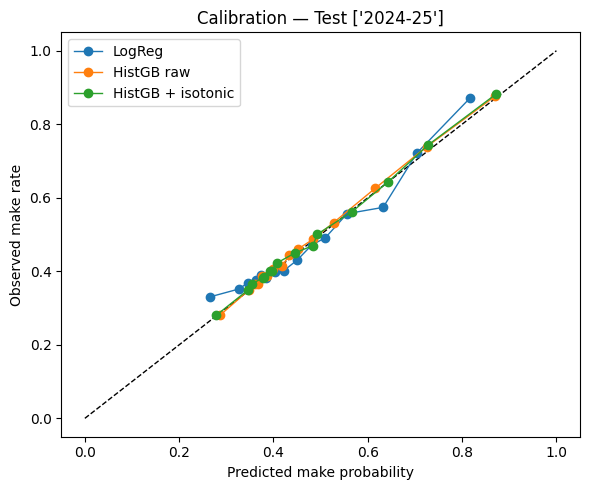


Team xEFG vs Actual (test; calibrated):
                         xEFG  EFG_ACTUAL  ShotMaking_vs_xEFG
TEAM_NAME                                                    
Cleveland Cavaliers     0.560       0.557              -0.004
Toronto Raptors         0.553       0.535              -0.018
San Antonio Spurs       0.551       0.532              -0.019
New York Knicks         0.547       0.540              -0.007
Memphis Grizzlies       0.546       0.509              -0.037
Oklahoma City Thunder   0.546       0.573               0.028
Dallas Mavericks        0.545       0.562               0.017
Minnesota Timberwolves  0.545       0.559               0.014
Atlanta Hawks           0.545       0.539              -0.005
Indiana Pacers          0.545       0.578               0.034
Denver Nuggets          0.545       0.562               0.017
Orlando Magic           0.544       0.541              -0.003
Los Angeles Lakers      0.544       0.566               0.023
Milwaukee Bucks         0.543

,xEFG,EFG_ACTUAL,ShotMaking_vs_xEFG
TEAM_NAME,,,
Atlanta Hawks,0.545,0.539,-0.005
Boston Celtics,0.539,0.578,0.039
Brooklyn Nets,0.543,0.531,-0.012
Charlotte Hornets,0.538,0.529,-0.008
Chicago Bulls,0.539,0.534,-0.005
Cleveland Cavaliers,0.560,0.557,-0.004
Dallas Mavericks,0.545,0.562,0.017
Denver Nuggets,0.545,0.562,0.017
Detroit Pistons,0.530,0.526,-0.004


In [43]:
def _as_set(x):
    if isinstance(x, (list, tuple, set)):
        return set(x)
    return {x}

train_set = _as_set(train_seasons)
test_set  = _as_set(test_season)

train_df = analyzer.features_df[analyzer.features_df["SEASON"].isin(train_set)].copy()
test_df  = analyzer.features_df[analyzer.features_df["SEASON"].isin(test_set)].copy()

for d in (train_df, test_df):
    d["SIN_ANGLE"] = np.sin(np.radians(d["SHOT_ANGLE"]))
    d["COS_ANGLE"] = np.cos(np.radians(d["SHOT_ANGLE"]))

base_numeric = [
    "SHOT_DISTANCE", "SIN_ANGLE", "COS_ANGLE",
    "IS_3PT", "IS_CORNER_3", "QUARTER", "TIME_REMAINING_SEC", "IS_HOME"
]
base_numeric = [c for c in base_numeric if c in train_df.columns]  # guard

cat_cols = [c for c in ["SHOT_ZONE", "ZONE_NAME", "ZONE_RANGE"] if c in train_df.columns]

TOPK_ACTIONS = 20
if "ACTION_TYPE" in train_df.columns:
    top_actions = train_df["ACTION_TYPE"].value_counts().head(TOPK_ACTIONS).index
    train_df["ACTION_REDUCED"] = np.where(train_df["ACTION_TYPE"].isin(top_actions),
                                          train_df["ACTION_TYPE"], "OTHER")
    test_df["ACTION_REDUCED"]  = np.where(test_df["ACTION_TYPE"].isin(top_actions),
                                          test_df["ACTION_TYPE"], "OTHER")
    cat_cols.append("ACTION_REDUCED")

train_cat = pd.get_dummies(train_df[cat_cols], prefix=cat_cols, drop_first=False)
test_cat  = pd.get_dummies(test_df[cat_cols],   prefix=cat_cols, drop_first=False)

for col in train_cat.columns:
    if col not in test_cat.columns:
        test_cat[col] = 0
extra_in_test = [c for c in test_cat.columns if c not in train_cat.columns]
if extra_in_test:
    test_cat = test_cat.drop(columns=extra_in_test)

X_train = pd.concat([train_df[base_numeric].reset_index(drop=True),
                     train_cat.reset_index(drop=True)], axis=1).astype(float).fillna(0)

X_test  = pd.concat([test_df[base_numeric].reset_index(drop=True),
                     test_cat.reset_index(drop=True)], axis=1).astype(float).fillna(0)

y_train = train_df["SHOT_MADE"].astype(int).values
y_test  = test_df["SHOT_MADE"].astype(int).values

print(f"Design matrix: X_train {X_train.shape} | X_test {X_test.shape} | "
      f"Numeric {len(base_numeric)} + Categorical {X_train.shape[1]-len(base_numeric)}")

decay_weights = {"2021-22": 0.25, "2022-23": 0.50, "2023-24": 1.00}
w_train = train_df["SEASON"].map(decay_weights).fillna(1.0).to_numpy()
print(f"Sample weights: min={w_train.min():.2f} max={w_train.max():.2f}")

lr = LogisticRegression(penalty="l2", solver="lbfgs", max_iter=1000)
lr.fit(X_train, y_train, sample_weight=w_train)

X_fit, X_cal, y_fit, y_cal, w_fit, w_cal = train_test_split(
    X_train, y_train, w_train, test_size=0.12, random_state=42, stratify=y_train
)

hgb = HistGradientBoostingClassifier(
    learning_rate=0.06, max_leaf_nodes=31, early_stopping=True,
    validation_fraction=0.1, max_iter=300, random_state=42
)
hgb.fit(X_fit, y_fit, sample_weight=w_fit)

cal_hgb = CalibratedClassifierCV(estimator=hgb, method="isotonic", cv="prefit")
cal_hgb.fit(X_cal, y_cal)  # (sample_weight for calibrator is optional & may not be supported across sklearn versions)

def eval_model(name, model, X_te, y_te):
    if hasattr(model, "predict_proba"):
        p = model.predict_proba(X_te)[:, 1]
    else:
        s = model.decision_function(X_te)
        p = 1.0 / (1.0 + np.exp(-s))
    brier = brier_score_loss(y_te, p)
    auc   = roc_auc_score(y_te, p)
    try:
        ll = log_loss(y_te, np.c_[1-p, p])
    except Exception:
        ll = np.nan
    print(f"{name:>12} | Brier: {brier:.5f}  AUC: {auc:.4f}  LogLoss: {ll:.5f}")
    return p

print("\n== Test metrics (with categorical context) ==")
p_lr      = eval_model("Logistic", lr,      X_test, y_test)
p_hgb     = eval_model("HistGB raw", hgb,   X_test, y_test)
p_hgb_iso = eval_model("HistGB + ISO", cal_hgb, X_test, y_test)

def plot_calibration(y_true, proba_dict, n_bins=15, title="Calibration (Reliability) — Test"):
    plt.figure(figsize=(6,5))
    plt.plot([0,1],[0,1], "k--", linewidth=1)
    for label, p in proba_dict.items():
        frac_pos, mean_pred = calibration_curve(y_true, p, n_bins=n_bins, strategy="quantile")
        plt.plot(mean_pred, frac_pos, marker="o", linewidth=1, label=label)
    plt.xlabel("Predicted make probability")
    plt.ylabel("Observed make rate")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_calibration(
    y_test,
    {"LogReg": p_lr, "HistGB raw": p_hgb, "HistGB + isotonic": p_hgb_iso},
    n_bins=15,
    title=f"Calibration — Test {sorted(test_set)}"
)

test_df = test_df.copy()
test_df["P_CAL"] = p_hgb_iso  # pick calibrated HGB for xEFG
is3 = (test_df["IS_3PT"] == 1).astype(float)
p   = test_df["P_CAL"].astype(float)
test_df["xEFG"] = (1.0 - is3)*p + 1.5*is3*p          # expected eFG per shot
made = test_df["SHOT_MADE"].astype(float)
test_df["EFG_ACTUAL"] = (1.0 - is3)*made + 1.5*is3*made

if "TEAM_NAME" in test_df.columns:
    team_summary = (test_df.groupby("TEAM_NAME")[["xEFG","EFG_ACTUAL"]]
                    .mean()
                    .assign(ShotMaking_vs_xEFG=lambda d: d["EFG_ACTUAL"] - d["xEFG"])
                    .sort_values("xEFG", ascending=False))
    print("\nTeam xEFG vs Actual (test; calibrated):")
    out = team_summary[display_cols].round(3)
    print(out.to_string())            # prints all rows
    # or, nicer in notebooks:
    display(out.sort_index())         # alphabetical
    team_summary[display_cols].round(3).to_csv("team_xEFG_2024_25.csv")